# Big Data Processing in PySpark

### Rain in Australia: Predict rain tomorrow in Australia using PySpark

Predicting rain or weather is a common problem in machine learning. Different machine learning algorithms can be used to model and predict rainfall. In this assignment, we ask you to complete the analysis to predict whether there will be rain tomorrow or not. In particular, you are required to apply the tools of machine learning to visualize and predict the possibility of rainfall in Australia.

#### Required libraries

We are using the Binary classification algorithms:

- Logistic Regression 
- Decession Tree Classifier 
- GBT Classifier (Gradient Boosted Trees)
- Random Forest Classifier 

In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import  StringIndexer,VectorAssembler
from pyspark.sql.functions import col, when , mean
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics,MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
import itertools

# A. Creating Spark Session and Loading the Data

## SparkContext and SparkSession
We will use and import **`SparkContext`** from **`pyspark`**, which is the main entry point for Spark Core functionality. The **`SparkSession`** object provides methods used to create DataFrames from various input sources. 
A [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) is equivalent to a relational table in Spark SQL, and can be created using various functions in SparkSession. Once created, it can be manipulated using the various domain-specific-language (DSL) functions defined in: [DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame), [Column](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column).


- local[4]: run Spark locally with 4 working processors as logical cores on your machine.
    
- We are running spark locally  with '4' worker threads, we can specify as `local[4]`.

- The `appName` field is a name to be shown on the Sparking cluster UI. The appname has been specified as Assignment 2 Application Design


In [2]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with '4' worker threads, we can specify as `local[4]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment 2 Application Design")
spark = SparkSession(sparkContext=sc)

## DataFrame: Loading the dataset

#### Step 02: Load the dataset and print the schema and total number of entries

#### Loading the dataset weatherAus.csv

In [3]:
# Load weather csv file using Spark csv package
weather_data = spark.read.csv('weatherAUS.csv', header=True, inferSchema=True)

In [4]:
weather_data.show(truncate=False)

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date               |Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|Albury  |13.4   |22.9   |0.6     |NA         |NA      |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |8       |NA      |16.9   |21.8   |

### printSchema:

Prints out the schema in tree format 

In [5]:
weather_data.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



#### Total no of entries in the datset

we are getting the count of total no of rows in the datset 

In [6]:
print("Total No of entries in the dataset : ",weather_data.count())

Total No of entries in the dataset :  142193


# B. Data Cleaning and Processing

### Step 03: Delete columns from the dataset

We are deleting the columns assuming that they are not going to make any impact on target varibale for predicion as we have other columns which had impact target variable.

As we are deleting  the following columns due to data quality and accuracy.

● Date

● Location

● Evaporation

● Sunshine

● Cloud9am

● Cloud3pm

● Temp9am

● Temp3pm

In [7]:
# displaying the columns present in the dataframe
str(weather_data)

'DataFrame[Date: timestamp, Location: string, MinTemp: string, MaxTemp: string, Rainfall: string, Evaporation: string, Sunshine: string, WindGustDir: string, WindGustSpeed: string, WindDir9am: string, WindDir3pm: string, WindSpeed9am: string, WindSpeed3pm: string, Humidity9am: string, Humidity3pm: string, Pressure9am: string, Pressure3pm: string, Cloud9am: string, Cloud3pm: string, Temp9am: string, Temp3pm: string, RainToday: string, RainTomorrow: string]'

In [8]:
#creating the list of columns to drop 
drop_list = ['Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# removing the columns from the dataframe which are in the list
weather_data = weather_data.select([column for column in weather_data.columns if column not in drop_list])


In [9]:
# storing the columns into cols variable
cols = weather_data.columns

 list of columns after deleting few columns from the dataframe 

In [10]:
cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

We are Considering the Australian Weather Data set, specifying the columns after removing the coulmns from the dataframe.

<b>` Data Description: ` </b>

<b>`Predictor Variables:`</b>

- `Min Temp` : Minimum Temparature recorded on the particular day

- `Max Temp` : Maximum Temparature Recored on the particular day

- `Rainfall` : Amount of Rainfall on a particular day

- `WindGustDir` : A wind gust is a sudden, seconds-long burst of high-speed wind that's followed by a lull. Specifying the direction of the Wind, different combinations of North, East, West, South (Specified as N, E, W, S)

- `WindGustSpeed` : A wind gust is a sudden, seconds-long burst of high-speed wind that's followed by a lull, Given the speed of the Wind on the particular day.

- `WindDir9am` : Specifying the Direction of the wind at 9am 

- `WindDir3pm` : Specifying the Direction of the wind at 3pm 

- `WindSpeed9am` : Speed of the wind at 9am of the particular day

- `WindSpeed3pm` : speed of the wind at 3 pm of the particular day

- `Humidity9am` : Humidity at the 9am of the particular day specified as numeric value 

- `Humidity3pm` : Humidity at the 3pm of the particular day specified as numeric value 

- `Pressure9am` : Pressure at 9am of the particular day specified as the numeric value 

- `Pressure3pm` : Pressure at 3pm of teh particular day specified as teh numeric value 

- `RainToday`  : Whether there is rain or not on the particular day or not, represented as the binary kind of variables `yes or no`

<b>`Target Variable:`</b>

- `RainTomorrow` :  Predicting the whether there will be rain Tomorrow or not based on the predictor variables

In [11]:
weather_data.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



# Step 04: Print the number of missing data in each column.

In [12]:
weather_data.show(20)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

In [13]:
weather_data.where(col('MinTemp').like("%N%")).show(5)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|     NA|   18.8|      NA|          N|           31|        SE|       NNE|           7|          19|         83|         46|     1022.2|     1018.2|       NA|          No|
|     NA|   31.2|      NA|        ESE|           31|       SSE|       SSW|           7|           7|         33|         24|     1020.4|     1019.1|       NA|          No|
|     NA|   26.3|      NA|         NE|           26|        SE|         E|           9|          13|         70|         62|     1019.4|    

#### `filter():`

Filter the rows of a DataFrame according to a given condition.

As we have verified on the column cell what is the represenation of NULL value in the column. From that we have found that in all the columns we are having null value in the form of `"NA"`

As we can see from the dataframe we are having the null values in the columns as specified as "NA"

We are counting the number of null values in each column, so we are counting the number of NA in each column.

In [14]:
print("Count of NA(NUll) Values in each column")
#Loop to iterate through each of the column 
for c in weather_data.columns:
    # printing the count of NA in each column 
    # filtering the column with the value given as NA since the column are of string type.
    print(c," : ",weather_data.filter((weather_data[c] == "NA")).count())
    

Count of NA(NUll) Values in each column
MinTemp  :  637
MaxTemp  :  322
Rainfall  :  1406
WindGustDir  :  9330
WindGustSpeed  :  9270
WindDir9am  :  10013
WindDir3pm  :  3778
WindSpeed9am  :  1348
WindSpeed3pm  :  2630
Humidity9am  :  1774
Humidity3pm  :  3610
Pressure9am  :  14014
Pressure3pm  :  13981
RainToday  :  1406
RainTomorrow  :  0


# Step 05: Fill the missing data with average value and maximum occurrence value.

In [15]:
weather_data.show(5)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

###### Identifying the Numeric and Non Numeric columns from the Dataframe:

As we can clearly observe from the dataframe what kind of data is in the dataframe based on that we are considered what kind is each column in the dataframe:

#### ` Numeric Columns:`

- MinTemp
- MaxTemp
- Rainfall
- WindGustSpeed
- WindSpeed9am
- WindSpeed3pm
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm

#### ` Non Numeric Columns:`

- WindGustDir
- WindDir9am
- WindDir3pm
- RainToday
- RainTomorrow


#### Replacing the NA values(Null values) with the average (mean) value, for the numeric column
#### Replacing the NA values(Null values) with the Maximum Occurence for the string column (Non - Numeric column)

Algorithm used:
    
1. Iterating through the columns in the dataframe
2. Checking whether the column is in set of columns which are non numeric columns

    2.1 if column is not non numeric, then we are finding the mean of that particular column 
    
    mean = sum of all observations/ total number of observations
                
    2.1.1 After finding the mean of the Numeric column then we are finding NA row in the column and replacing      with the mean, otherwie will be keeping the same value in the colum.
        
3. Checking the column is Non Numeric column from the set, if the column is in the set

    3.1 We are finding the high frequency word in the column and replacing the NA row of the column with the high frequency word of the column.
    
    3.2 first we have selected all strings of column into list , we are finding the frequency using reduceByKey() function.
    
    3.3 Then replacing the column value .
    
4. Returning the data frame after performing the actions

`when()` : sql function is used to replace the column value when the condition value is true, if not we will be using the same value of teh column using otherwise()

##### Function for replacing the NA values in the column 

In [16]:
# Importing the when and mean functions from sql.functions 
from pyspark.sql.functions import when,mean
# created the function to replace the NA values in the column
# function takes the argument dataframe, string type column names 
def impute_NA_values(weather_data, exclude):
    # now we are iterating through the each column 
    for c in weather_data.columns:
        # now checking whether it is the string column or not, if not then will proceed 
        if c not in exclude:
            #now we are finding the average of the column values and stored as a list
            m = weather_data.select(mean(c).alias('avg')).collect()
            #now getting the mean value of the column, as it is in the key value pair in the list we are extracting
            # based on indices.
            l = [row['avg'] for row in m][0]
            # replacing the NA values in the column with the mean of the column other wise we are leaving the column
            # value as it is
            print("Mean of the column ",c," : ",l)
            weather_data = weather_data.withColumn(c,when(weather_data[c] == "NA", l).otherwise(weather_data[c]))
        # now checking the column with string type 
        if c in exclude:
            # select the values of the column and converting it to the RDD 
            words = weather_data.select(weather_data[c].alias("words")).rdd
            # we are counting the frequency of each word in the RDD
            s = words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)
            # we are arranging in the descending order and taking the top one 
            s1 = s.takeOrdered(1, key = lambda x: -x[1])[0][0][0]
            print("High Frequency word in column ",c," : ",s1)
            # now replacing the column with NA values with the high frequency word 
            weather_data = weather_data.withColumn(c,when(weather_data[c] == "NA", s1).otherwise(weather_data[c]))
    # return the weather_data data frame 
    return(weather_data)

#### Function Call to fill with mean and frequency

As we are selecting the columns with String and passing it to the function, so that we can sepearate the numeric and Numeric column in the function 

In [17]:
# returns the dataframe from the function
# now calling the function with parameters dataframe and columns with the string type
print(" Mean of the Numeric Column and High frequency word of the Non Numeric Column")
weather_data = impute_NA_values(weather_data, ["WindGustDir", "WindDir9am","WindDir3pm","RainToday","RainTomorrow"])

 Mean of the Numeric Column and High frequency word of the Non Numeric Column
Mean of the column  MinTemp  :  12.186399728729311
Mean of the column  MaxTemp  :  23.2267841912725
Mean of the column  Rainfall  :  2.3499740743107442
High Frequency word in column  WindGustDir  :  W
Mean of the column  WindGustSpeed  :  39.98429165757619
High Frequency word in column  WindDir9am  :  N
High Frequency word in column  WindDir3pm  :  SE
Mean of the column  WindSpeed9am  :  14.001988000994
Mean of the column  WindSpeed3pm  :  18.63757586179718
Mean of the column  Humidity9am  :  68.8438103105705
Mean of the column  Humidity3pm  :  51.482606091656265
Mean of the column  Pressure9am  :  1017.6537584159615
Mean of the column  Pressure3pm  :  1015.2582035378894
High Frequency word in column  RainToday  :  No
High Frequency word in column  RainTomorrow  :  No


We are printing out again how many no of null values in the column 

Checking whether count is equal to 0

In [18]:
print("Count of NA(NUll) Values in each column")
#Loop to iterate through each of the column 
for c in weather_data.columns:
    # printing the count of NA in each column 
    print(c," : ",weather_data.filter((weather_data[c] == "NA")).count())
    

Count of NA(NUll) Values in each column
MinTemp  :  0
MaxTemp  :  0
Rainfall  :  0
WindGustDir  :  0
WindGustSpeed  :  0
WindDir9am  :  0
WindDir3pm  :  0
WindSpeed9am  :  0
WindSpeed3pm  :  0
Humidity9am  :  0
Humidity3pm  :  0
Pressure9am  :  0
Pressure3pm  :  0
RainToday  :  0
RainTomorrow  :  0


As we can see that we have replaced all the NA values of the column, since count of NA is 0

In [19]:
weather_data.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Steps Performed till now:
    
- we have removed the few columns from the dataframe
- Replaced the NA vlue in the column with the mean and High frequecy of the columns 

Now we can apply tranformations on the data

# Step 06: Data transformation

## Transformers
A **Transformer** is an abstraction which includes feature transformers and learned models.  Technically, a Transformer implements a method ``transform()`` which converts one  ``SchemaRDD`` into another, generally by appending one or more columns. For example:
- A feature transformer might take a dataset, read a column (e.g., text), convert it into a new column (e.g., feature vectors), append the new column to the dataset, and output the updated dataset.
- A learning model might take a dataset, read the column containing feature vectors, predict the label for each feature vector, append the labels as a new column, and output the updated dataset.


### Extractors

> - Numeric columns: For numeric features, the hash value of the column name is used to map the feature value to its index in the feature vector. By default, numeric features are not treated as categorical (even when they are integers). To treat them as categorical, you can specify the relevant columns using the `categoricalCols` parameter.
- String columns: For categorical features, the hash value of the string “column_name=value” is used to map to the vector index, with an indicator value of 1.0. 
- Boolean columns: Boolean values are treated in the same way as string columns. That is, boolean features are represented as “column_name=true” or “column_name=false”, with an indicator value of 1.0.

## Pipeline
In machine learning, it is common to run a sequence of algorithms to process and learn from data. E.g., a simple text document processing workflow might include several stages:

- Split each document’s text into words.
- Convert each document’s words into a numerical feature vector.
- Learn a prediction model using the feature vectors and labels.

Spark ML represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. We will use this simple workflow as a running example in this section.


### Identifying the numerical columns and String type columns 

So that we can create separate list of these columns and then we can perform transformations on the data

In [20]:
# list of columns with the Numeric type of data, wher we will be type casting it to the double type 
numericCols = ["MinTemp","MaxTemp","Rainfall","WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am",
               "Humidity3pm","Pressure9am","Pressure3pm"]
# list of columns with the Non Numeric type of data where we can transform the data to the StringIndexes 
string_cols = ["WindGustDir", "WindDir9am","WindDir3pm","RainToday"]
# we have list as traget cols as it holds the target cell 
target_cols = ["RainTomorrow"]

### Typecasting numerical columns to double 

In [21]:
# Iterating trough the columns in the numericCols and we are typecasting it to the double 
for c in numericCols:
    # as we are transforming the data type of the column and we are assigning back to the column
    weather_data = weather_data.withColumn(c, weather_data[c].cast("double"))

In [22]:
weather_data.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



We can see that data type of the NumericCols has been changed from the String to the Double

### Converting the String type of data to String Indexes

indexers is the list which holds all the IDS of string indexes which are converting

In [23]:
#String columns other than the Target Column to the String Indexers 
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(weather_data).setHandleInvalid("skip")\
            for column in list(set(string_cols))]
#Converting the target column to the String Indexers and labeling the output column as label  
label_stringIdx = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')
# Adding the Label String Index to the list of string indexes 
indexers += [label_stringIdx]

# Step 07: Create the feature vector and divide the dataset

Creating the feture vector of numeric cols and stringIndexer columns, since feature vector holds the Numetic data

In [24]:
# creating the list of all the columns except the Target variable column 
assemblerInputs = [c + "_index" for c in string_cols] + numericCols
# now converting the columns to the Feature vector 
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
# adding the feature vector variable to the indexers list, to pass it to the pipeline 
indexers += [assembler]

### Passing list to the pipeline 

In [25]:
pipeline = Pipeline(stages=indexers)

In [26]:
dataset = pipeline.fit(weather_data).transform(weather_data)
dataset.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)
 |-- WindGustDir_index: double (nullable = false)
 |-- RainToday_index: double (nullable = false)
 |-- WindDir9am_index: double (nullable = false)
 |-- WindDir3pm_index: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [27]:
dataset.show(5)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+---------------+----------------+----------------+-----+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDir_index|RainToday_index|WindDir9am_index|WindDir3pm_index|label|            features|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+---------------+----------------+----------------+-----+--------------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|              0.0|          

#### Creating the dataframe with the columns and the label and feature vector

In [28]:
#Choose only label and features to create a dataframe
selectedCols = ['label', 'features'] + cols 
df = dataset.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [29]:
df.show(5)

+-----+--------------------+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|label|            features|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-----+--------------------+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|  0.0|[0.0,6.0,7.0,0.0,...|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|
|  0.0|[9.0,9.0,3.0,0.0,...|    7.4|   25.1|     0.0|        WNW|         44.0|       NNW|       WSW|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|       No|          No|
|  0.

### Training and Test Data set 

We are creating the training and testing dataset by the dataset into 70% and 30%

70% of training data and 30% of testing data 

In [30]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 99626
Test Dataset Count: 42567


# C. Apply Machine Learning Algorithms

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

# Logistic Regression

*Logistic Regression* is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. To represent binary/categorical outcome, we use dummy variables. You can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.


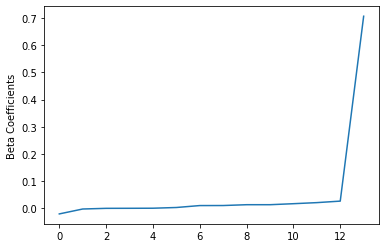

In [31]:
# Create an initial model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label',    maxIter=10)
lrModel = lr.fit(train)

#LogisticRegressionModel to get the beta coefficient.
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

plt.show()
plt.close()

In [32]:
# LogicRegression.transform() is a method that uses only 'features'.
lr_predictions = lrModel.transform(test)

#At this point, you can select a column for the schema to view the forecasts.
lr_predictions.select('MinTemp', 'WindDir9am','Humidity9am','Pressure9am','RainToday', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

# The BinaryClassificationEvaluator is used to evaluate the model.
evaluator = BinaryClassificationEvaluator()
lr_accuracy = evaluator.evaluate(lr_predictions)
print('Test Area Under ROC', evaluator.evaluate(lr_predictions))

+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|MinTemp|WindDir9am|Humidity9am|       Pressure9am|RainToday|label|       rawPrediction|prediction|         probability|
+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|    5.4|         N|       98.0|1017.6537584159615|       No|  0.0|[1.99745907329365...|       0.0|[0.88053003873525...|
|    7.9|         N|       99.0|            1023.4|       No|  0.0|[1.00558354824098...|       0.0|[0.73215495353307...|
|   -0.1|         N|       99.0|            1019.8|       No|  0.0|[1.78351973034014...|       0.0|[0.85613093740828...|
|    3.5|         N|       85.0|1017.6537584159615|       No|  0.0|[2.29491666427921...|       0.0|[0.90845516337906...|
|    6.4|         N|       97.0|            1018.9|       No|  0.0|[1.96326095082335...|       0.0|[0.87688542900353...|
|    9.0|         N|       99.0|

## Decision Tree Classifier Implementation
Decision tree algorithms are said to be widely used because they process categorical data and are readily available in classification tasks by multiple classes.


A *decision tree* is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility.



In [33]:
# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 25)
dtModel = dt.fit(train)

#Use the  Transformer.transform() method to predict test data
dt_predictions = dtModel.transform(test)

#Provisions and probabilities for each selected forecasting class
dt_predictions.select('MinTemp', 'WindDir9am','Humidity9am','Pressure9am','RainToday','label','rawPrediction', 'prediction', 'probability').show(10)


+-------+----------+-----------+------------------+---------+-----+-------------+----------+-----------+
|MinTemp|WindDir9am|Humidity9am|       Pressure9am|RainToday|label|rawPrediction|prediction|probability|
+-------+----------+-----------+------------------+---------+-----+-------------+----------+-----------+
|    5.4|         N|       98.0|1017.6537584159615|       No|  0.0|  [124.0,0.0]|       0.0|  [1.0,0.0]|
|    7.9|         N|       99.0|            1023.4|       No|  0.0|   [17.0,0.0]|       0.0|  [1.0,0.0]|
|   -0.1|         N|       99.0|            1019.8|       No|  0.0|  [152.0,0.0]|       0.0|  [1.0,0.0]|
|    3.5|         N|       85.0|1017.6537584159615|       No|  0.0|  [124.0,0.0]|       0.0|  [1.0,0.0]|
|    6.4|         N|       97.0|            1018.9|       No|  0.0|   [61.0,0.0]|       0.0|  [1.0,0.0]|
|    9.0|         N|       99.0|            1022.4|       No|  0.0|    [4.0,0.0]|       0.0|  [1.0,0.0]|
|    7.6|         N|       99.0|            1029.9|    

In [34]:
evaluator = BinaryClassificationEvaluator()
binary_accuracy = evaluator.evaluate(dt_predictions)
print("Test Area Under ROC: " + str(evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7124044216120095


 ## Implementing the Gradient-Boosted Tree Classifier
 
*Boosting* means combining simple and weak learners to create more accurate and powerful ones. Even if the accuracy is low, once the model is created, the weaknesses (forecasting errors) are complemented by the second model. Because when these two are combined, the exact model is created rather than the first, and the problem that remains is the principle of iterating the process of supplementing and adding to the next model.


In [35]:
gbt = GBTClassifier(maxIter=20)
gbtModel = gbt.fit(train)
gbt_predictions = gbtModel.transform(test)
gbt_predictions.select('MinTemp', 'WindDir9am','Humidity9am','Pressure9am','RainToday', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
 
#Use the #BinaryClassificationEvaluator method to evaluate the accuracy of the model
evaluator = BinaryClassificationEvaluator()
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Test Area Under ROC: " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))
 
#Use explainParams() to output a list of all parameters and their definitions
print("\n",gbt.explainParams())

+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|MinTemp|WindDir9am|Humidity9am|       Pressure9am|RainToday|label|       rawPrediction|prediction|         probability|
+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|    5.4|         N|       98.0|1017.6537584159615|       No|  0.0|[1.20981631649254...|       0.0|[0.91831219076906...|
|    7.9|         N|       99.0|            1023.4|       No|  0.0|[0.42642345552010...|       0.0|[0.70116400582484...|
|   -0.1|         N|       99.0|            1019.8|       No|  0.0|[1.11998847790747...|       0.0|[0.90378245439185...|
|    3.5|         N|       85.0|1017.6537584159615|       No|  0.0|[1.30491472732623...|       0.0|[0.93149151371263...|
|    6.4|         N|       97.0|            1018.9|       No|  0.0|[1.06765274872922...|       0.0|[0.89428762580315...|
|    9.0|         N|       99.0|

## Random forest algorithm

In [36]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees=20)

model = rf.fit(train)

rf_predictions = model.transform(test)

rf_predictions.select('MinTemp', 'WindDir9am','Humidity9am','Pressure9am','RainToday', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


evaluator = BinaryClassificationEvaluator()

rf_accuracy = evaluator.evaluate(rf_predictions)

print("Test Area Under ROC: " + str(evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})))

+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|MinTemp|WindDir9am|Humidity9am|       Pressure9am|RainToday|label|       rawPrediction|prediction|         probability|
+-------+----------+-----------+------------------+---------+-----+--------------------+----------+--------------------+
|    5.4|         N|       98.0|1017.6537584159615|       No|  0.0|[17.4928954844736...|       0.0|[0.87464477422368...|
|    7.9|         N|       99.0|            1023.4|       No|  0.0|[14.2393343442020...|       0.0|[0.71196671721010...|
|   -0.1|         N|       99.0|            1019.8|       No|  0.0|[17.5698533815786...|       0.0|[0.87849266907893...|
|    3.5|         N|       85.0|1017.6537584159615|       No|  0.0|[17.4928954844736...|       0.0|[0.87464477422368...|
|    6.4|         N|       97.0|            1018.9|       No|  0.0|[17.5131119263795...|       0.0|[0.87565559631897...|
|    9.0|         N|       99.0|

### Bar plot of different accuracies 

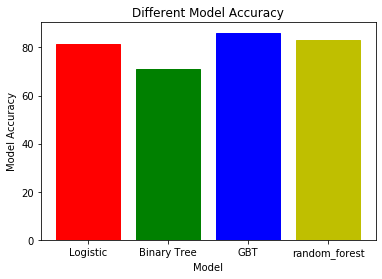

In [37]:

X = ['Logistic','Binary Tree','GBT','random_forest']
Y = [lr_accuracy*100,binary_accuracy*100,gbt_accuracy*100,rf_accuracy*100]

barlist = plt.bar(X, Y)
plt.title("Different Model Accuracy")
plt.ylabel('Model Accuracy')
plt.xlabel('Model')
barlist[0].set_color('r')
barlist[1].set_color('g')
barlist[2].set_color('b')
barlist[3].set_color('y')
plt.show()



As we can see from above plot, we can clearly say that Grandient Boost Technique, has outperformed when compared to the other classification techniques.

As we can see that it is beacuse of the number of iterations and considering the repated data in the Boosting technique.

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

## `Confusion Matrix:`

Confusion matrix is a table, which is used to measure the performance of the classification model on a set of test for which true values are known.

Can identify the confusion between the clasees in wich one class is misclassified as the other class. Performance measures are compared using th confusion matrix.

                        class1         class2
                        Predicted NO   Predicted YES
            
            class1         TN             FP
            Actual NO
            
            class2         FN             TP
            Actual YES
        
Here,

- Class 1 : Negative (no)

- Class 2 : Positive (yes)

Definition of the Terms:

- Positive (P) : Observation is positive (for example: is an apple).

- Negative (N) : Observation is not positive (for example: is not an apple).

- True Positive (TP) : Observation is positive, and is predicted to be positive.

- False Negative (FN) : Observation is positive, but is predicted negative.

- True Negative (TN) : Observation is negative, and is predicted to be negative.

- False Positive (FP) : Observation is negative, but is predicted positive.

Classification Rate/Accuracy:
Classification Rate or Accuracy is given by the relation:

accuracy = $\frac{TP+TN}{TP+TN+FP+FN}$

#### Confusion Matrix for Logistic Regression

In [38]:
predictionRDD = lr_predictions.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
cnf_matrix = metrics.confusionMatrix().toArray()
cnf_matrix

array([[30810.,  2248.],
       [ 5564.,  3945.]])

In [39]:
print("Accuracy Score : ", metrics.accuracy)

Accuracy Score :  0.8164775530340405


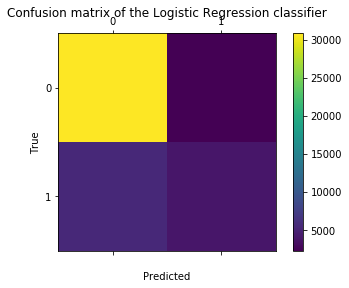

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the Logistic Regression classifier')
fig.colorbar(cax)
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('True')
plt.show()

### `Recall:`

Recall can be defined as the ratio of the total number of correctly classified positive divide to the total number of positive 

High Recall indicates the class is correctly recognized (small number of FN).

Recall =  $\frac{TP}{TP+FN}$

### `Precision Score:`

the value of precision we divide the total number of correctly classified positive  by the total number of predicted positive.

High Precision indicates an example labeled as positive is indeed positive (small number of FP).


precision = $\frac{TP}{TP+FP}$

`High recall, low precision:` This means that most of the positive  are correctly recognized (low FN) but there are a lot of false positives.

`Low recall, high precision:` This shows that we miss a lot of positive  (high FN) but those we predict as positive are indeed positive (low FP) 

### `F1 score:`

F-measure which uses Harmonic Mean in place of Arithmetic Mean as it punishes the extreme values more.

The F-Measure will always be nearer to the smaller value of Precision or Recall.

F1 score = $\frac{2*Recall*Precesion}{Recal+Precesion}$

###### Precesion, recal and f1 score for Logistic Regression

In [41]:
labels = [0.0,1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print("*****")

Class 0.0 precision = 0.8470335954253038
Class 0.0 recall = 0.931998306007623
Class 0.0 F1 Measure = 0.8874870376771518
*****
Class 1.0 precision = 0.637009526885193
Class 1.0 recall = 0.41487012304132925
Class 1.0 F1 Measure = 0.5024837600305694
*****


As we can say that, recall is lower than the precision, that means we miss lot of positive in this model.

##### Confusion matrix for Decession tree

In [42]:
predictionRDD = dt_predictions.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
cnf_matrix = metrics.confusionMatrix().toArray()
cnf_matrix

array([[27489.,  5569.],
       [ 4243.,  5266.]])

In [43]:
print("Accuracy Score : ", metrics.accuracy)

Accuracy Score :  0.7694927995865342


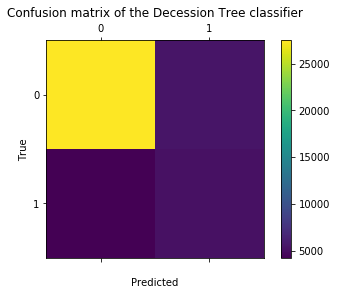

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the Decession Tree classifier', y =1.08)
fig.colorbar(cax)
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('True')
plt.show()

###### Precesion , recall, F1 score for decession tree 

In [45]:
labels = [0.0,1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print("*****")

Class 0.0 precision = 0.866286398588176
Class 0.0 recall = 0.8315385080767137
Class 0.0 F1 Measure = 0.8485568760611206
*****
Class 1.0 precision = 0.48601753576372864
Class 1.0 recall = 0.553791145230834
Class 1.0 F1 Measure = 0.517695635076681
*****


As we can see that recall is greater than the precesion, this means lot of positive are correctly classified 

##### Confusion matrix for GBT 

In [46]:
predictionRDD = gbt_predictions.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
cnf_matrix = metrics.confusionMatrix().toArray()
cnf_matrix

array([[31410.,  1648.],
       [ 5041.,  4468.]])

In [47]:
print("Accuracy Score : ", metrics.accuracy)

Accuracy Score :  0.8428594920948153


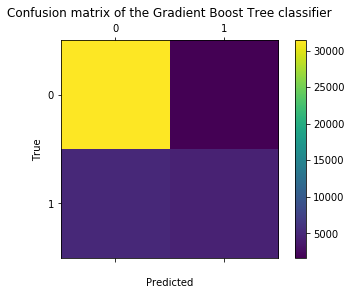

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the Gradient Boost Tree classifier', y =1.08)
fig.colorbar(cax)
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('True')
plt.show()

##### Precision, recall and F1 score for GBT

In [49]:
labels = [0.0,1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print("****")

Class 0.0 precision = 0.8617047543277276
Class 0.0 recall = 0.9501482243329905
Class 0.0 F1 Measure = 0.9037678573997612
****
Class 1.0 precision = 0.7305428384565075
Class 1.0 recall = 0.4698706488589757
Class 1.0 F1 Measure = 0.571904
****


As we can see that, precision is greater than the recall, this shows that we misssed lot of positive classifications

##### Confusion matrix for Random Forest:

In [50]:
predictionRDD = rf_predictions.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(predictionRDD)
cnf_matrix = metrics.confusionMatrix().toArray()
cnf_matrix

array([[32145.,   913.],
       [ 6258.,  3251.]])

In [51]:
print("Accuracy Score : ", metrics.accuracy)

Accuracy Score :  0.8315361665139662


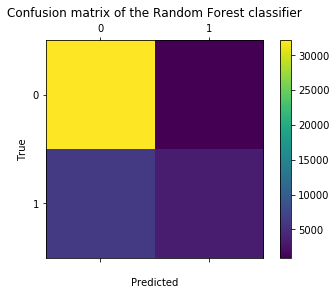

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the Random Forest classifier',y=1.08)
fig.colorbar(cax)
plt.xlabel('Predicted', labelpad=20)
plt.ylabel('True')
plt.show()

#### precision, recall and F1 score for Random forest

In [53]:
labels = [0.0,1.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print("****")

Class 0.0 precision = 0.8370439809389891
Class 0.0 recall = 0.9723818742815658
Class 0.0 F1 Measure = 0.8996515581925805
****
Class 1.0 precision = 0.7807396733909702
Class 1.0 recall = 0.3418866337154275
Class 1.0 F1 Measure = 0.4755357273458642
****


As we ca see that Precision is greater than the Recall, this means that we can say that we missed lot of positive classifications 

### Conclusion:
  
As we can see from the above models, GBT classifier has done well when compared to the other classification techniques.

Since F score is calculated based on the precisiona nd recall, for better accuracy instead of increasing the value of precision ad recall metrics individual (which is hard improvising one will reduce the other value) we can try to maximize the value of f-score of a model.<br>

One other way is to tune the hyperparameters before generating the final model, because we externally give the hyper parameters and these value affect the model performance